# PDE

We are going to solve the partial derivative equation for a harmonic oscillator in one dimension, defined over a grid $[a, b]$, as in
$$H = -\frac{1}{2m}\partial_x^2 + \frac{1}{2}m\omega^2x^2$$

The following function creates the MPO for this PDE.

In [1]:
from seemps.analysis.finite_differences import finite_differences_mpo
from seemps.analysis.operators import x_to_n_mpo
from seemps.operators import MPOSum
from seemps.state import DEFAULT_STRATEGY, Strategy, product_state
import numpy as np


def harmonic_oscillator_mpo(
    n: int,
    a: float = 0,
    b: float | None = None,
    m: float = 1,
    ω: float = 1,
    closed: bool = True,
    operator_strategy: Strategy = DEFAULT_STRATEGY,
):
    """Create the MPO of the quantum harmonic oscillator.

    Parameters
    ----------
    n: int
        Number of qubits for the position space.
    a: float
        Initial point of the position space interval (default is -3).
    b: float | None, default = a
        Final point of the space interval
    m : np.ndarray
        Mass of the harmonic oscillator (default is 1).
    ω : np.ndarray
        Angular frequency of the harmonic oscillator (default is 1).
    closed : bool
        True if finite differences are periodic (defaults to True).
    operator_strategy : Strategy
        MPO truncation strategy (default is DEFAULT_STRATEGY).

    return
    ------
    x
        Array of coordinates in which the problem is defined
    MPO
        Harmonic oscillator MPO.
    """
    if b is None:
        b = -a
    x = np.linspace(a, b, 2**n + 1)[:-1]
    dx = x[1] - x[0]

    potential = (
        0.5
        * m
        * ω**2
        * x_to_n_mpo(
            n,
            a,
            dx,
            strategy=operator_strategy,
            n=2,
        )
    )
    derivative = (-0.5 / m) * finite_differences_mpo(
        n, dx, closed=closed, strategy=operator_strategy
    )

    return x, MPOSum([potential, derivative]).join(strategy=operator_strategy)

We solve this problem by computing the ground state using some solver, inn this case DMRG, for different grid densities, inspecting the error in the eigenvalue:

n = 3 qubits, E = 0.4273507338041203
n = 4 qubits, E = 0.4874703669642789
n = 5 qubits, E = 0.49692926495070094
n = 6 qubits, E = 0.4992358909246792
n = 7 qubits, E = 0.4998091922081227
n = 8 qubits, E = 0.49995231165405435
n = 9 qubits, E = 0.4999880787063433
n = 10 qubits, E = 0.4999970196708803
n = 11 qubits, E = 0.4999992548664596
n = 12 qubits, E = 0.49999981364139523
n = 13 qubits, E = 0.49999995338578934
n = 14 qubits, E = 0.49999998827469866


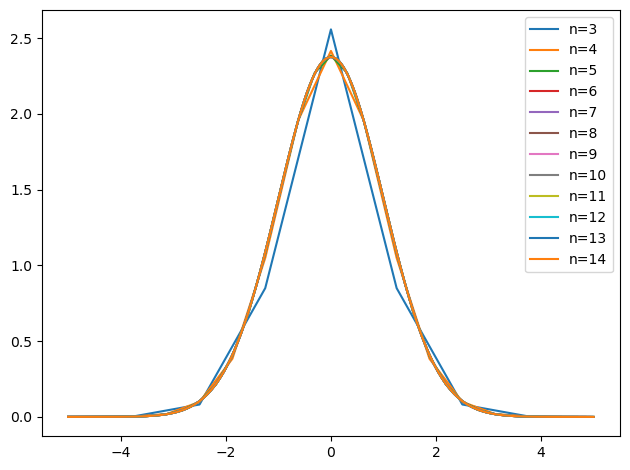

In [2]:
from seemps.optimization import dmrg
import matplotlib.pyplot as plt
import numpy as np


def experiment_0(nmax: int, a: float = -5):
    fig, ax = plt.subplots()
    for n in range(3, nmax):
        x, H = harmonic_oscillator_mpo(n, a)
        guess = product_state(np.ones(2) / np.sqrt(2), n)
        result = dmrg(H, guess=guess, maxiter=50)
        print(f"n = {n} qubits, E = {result.energy}")
        psi = np.abs(result.state.to_vector()) * np.sqrt(2**n)
        ax.plot(x, psi, label=f"n={n}")
    ax.legend()
    fig.tight_layout()


experiment_0(15)